In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import os
import sys


# Zakładam, że folder 'scripts' jest na tym samym poziomie co 'notebooks'
scripts_path = os.path.abspath(os.path.join('..', 'scripts'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

# Teraz możesz importować moduł
from predicting_odor_from_molecular_structure import *


df = goodscents()
df.head()

,TGSC ID,CID,Concentration %,Solvent,MolecularWeight,IsomericSMILES,IUPACName,name,Labels,mol
0,1000111,7476,100.0,NaN,150.17,CC(=O)C1=CC=C(C=C1)OC,1-(4-methoxyphenyl)ethanone,4'-methoxyacetophenone,"[sweet, vanilla, cherry maraschino cherry, pow...",<rdkit.Chem.rdchem.Mol object at 0x0000025CCCE...
1,1031871,7478,10.0,dipropylene glycol,152.15,COC1=CC=C(C=C1)C(=O)O,4-methoxybenzoic acid,4-methoxybenzoic acid,"[phenolic, animal, fecal, medicinal]",<rdkit.Chem.rdchem.Mol object at 0x0000025CCCE...
2,1009281,7501,0.1,triacetin,104.15,C=CC1=CC=CC=C1,styrene,styrene,"[sweet, plastic, floral, balsamic]",<rdkit.Chem.rdchem.Mol object at 0x0000025CCCE...
3,1001651,244,100.0,NaN,108.14,C1=CC=C(C=C1)CO,phenylmethanol,benzyl alcohol,"[sweet, floral, rose, fruity, phenolic, balsam...",<rdkit.Chem.rdchem.Mol object at 0x0000025CCCE...
4,1001491,240,10.0,dipropylene glycol,106.12,C1=CC=C(C=C1)C=O,benzaldehyde,benzaldehyde,"[sweet, cherry, cherry maraschino cherry, nutt...",<rdkit.Chem.rdchem.Mol object at 0x0000025CCCE...


In [3]:
df = reduce_df(df, minimum=30)
df.shape

(4506, 10)

### Featurization

In [5]:
morgan, daylight = create_all_features(df)
morgan, daylight

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [6]:
mordred = create_mordred_features_cleaned(df)
mordred

100%|██████████| 4506/4506 [00:51<00:00, 86.98it/s] 


array([[ 7.95651408,  7.45186446,  0.        , ..., 55.        ,
         4.58333333,  2.61111111],
       [ 7.95651408,  7.45186446,  1.        , ..., 55.        ,
         4.58333333,  2.61111111],
       [ 5.65685425,  5.42766007,  0.        , ..., 36.        ,
         2.61111111,  2.        ],
       ...,
       [ 7.88756439,  7.27632423,  0.        , ..., 51.        ,
         3.97222222,  2.66666667],
       [ 5.05913727,  5.43650183,  0.        , ..., 27.        ,
         4.11111111,  2.16666667],
       [ 5.05913727,  5.43650183,  0.        , ..., 27.        ,
         4.11111111,  2.16666667]])

### Training

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

classes = label_frequencies(df, labels_column='Labels').Label.to_list()
mlb = MultiLabelBinarizer(classes=classes)
Y = mlb.fit_transform(df['Labels'])

mlb, Y.shape

(MultiLabelBinarizer(classes=['fruity', 'green', 'sweet', 'floral', 'woody',
                              'herbal', 'fatty', 'fresh', 'waxy', 'spicy',
                              'citrus', 'rose', 'sulfurous', 'earthy', 'nutty',
                              'tropical', 'odorless', 'balsamic', 'oily',
                              'minty', 'vegetable', 'powdery', 'musty', 'meaty',
                              'creamy', 'pineapple', 'apple', 'aldehydic',
                              'roasted', 'phenolic', ...]),
 (4506, 133))

In [9]:
# # Morgan i Daylight już są jako listy 0/1 w df
# X_morgan = np.array(df['morgan_fp'].tolist())
# X_daylight = np.array(df['daylight_fp'].tolist())


feature_sets = {
    'Morgan': morgan,
    'Daylight': daylight,
    'Mordred': mordred,
}


feature_sets


{'Morgan': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]]),
 'Daylight': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'Mordred': array([[ 7.95651408,  7.45186446,  0.        , ..., 55.        ,
          4.58333333,  2.61111111],
        [ 7.95651408,  7.45186446,  1.        , ..., 55.        ,
          4.58333333,  2.61111111],
        [ 5.65685425,  5.42766007,  0.        , ..., 36.        ,
          2.61111111,  2.        ],
        ...,
        [ 7.88756439,  7.27632423,  0.        , ..., 51.        ,
          3.97222222,  2.66666667],
        [ 5.05913727,  5.43650183,  0.        , ..., 27.        ,
          4.11111111,  2.16666667],
        [ 5.059137

In [10]:
for k, v in feature_sets.items():
    print(v.shape)

(4506, 2048)
(4506, 2048)
(4506, 1539)


In [12]:
indices = np.arange(len(df))
# Dodaj indeks jako ostatnią kolumnę do cech (np. Mordred)
X_with_idx = np.concatenate([mordred, indices.reshape(-1, 1)], axis=1)
X_train, y_train, X_test, y_test = iterative_train_test_split(X_with_idx, Y, test_size=0.2)
train_indices = X_train[:, -1].astype(int)
test_indices = X_test[:, -1].astype(int)

def get_split(X, train_idx, test_idx):
    return X[train_idx], X[test_idx]


In [13]:

from sklearn.neighbors import KNeighborsClassifier


model_types = {
    'RF': lambda: RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    #'Chain': lambda: ClassifierChain(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    'KNN': lambda: KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

results = []
models = {}

for feat_name, X in feature_sets.items():
    X_train_, X_test_ = get_split(X, train_indices, test_indices)
    for model_name, model_init in model_types.items():
        key = f"{feat_name}_{model_name}"
        print(f"Trenuję {key} ...")
        model = model_init()
        model.fit(X_train_, y_train)
        y_pred = model.predict(X_test_)
        if hasattr(y_pred, "toarray"):
            y_pred = y_pred.toarray()
        # Metryki per-label
        precision = precision_score(y_test, y_pred, average=None, zero_division=0)
        recall = recall_score(y_test, y_pred, average=None, zero_division=0)
        f1 = f1_score(y_test, y_pred, average=None, zero_division=0)
        results.append({
            'model': key,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        # Zapisz wytrenowany model i predykcje do późniejszej inferencji
        models[key] = {
            'model': model,
            'y_pred': y_pred,
            'X_test': X_test_,
            'y_test': y_test,
            'test_indices': test_indices
        }



Trenuję Morgan_RF ...
Trenuję Morgan_KNN ...
Trenuję Daylight_RF ...
Trenuję Daylight_KNN ...
Trenuję Mordred_RF ...
Trenuję Mordred_KNN ...


In [14]:
import numpy as np
import pandas as pd


summary_stats = []

for model_key, model_data in models.items():
    y_test = model_data['y_test']
    y_pred = model_data['y_pred']

    # Probabilistyczne predykcje do ROC-AUC (jeśli model obsługuje)
    y_proba = None
    try:
        if hasattr(model_data['model'], "predict_proba"):
            y_proba_list = model_data['model'].predict_proba(model_data['X_test'])
            if isinstance(y_proba_list, list) or isinstance(y_proba_list, tuple):
                y_proba = np.stack([p[:, 1] for p in y_proba_list], axis=1)
            else:
                y_proba = y_proba_list
    except Exception:
        y_proba = None

    # Metryki dla całego zbioru
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    # ROC-AUC macro
    try:
        if y_proba is not None:
            roc_auc_macro = roc_auc_score(y_test, y_proba, average='macro')
        else:
            roc_auc_macro = np.nan
    except Exception:
        roc_auc_macro = np.nan

    summary_stats.append({
        'model': model_key,
        'roc_auc_macro': roc_auc_macro,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro
    })

summary_df = pd.DataFrame(summary_stats)
summary_df


,model,roc_auc_macro,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro
0,Morgan_RF,0.785751,0.288344,0.149736,0.540644,0.377048,0.196598,0.102618
1,Morgan_KNN,0.690413,0.276318,0.129106,0.491792,0.279314,0.192136,0.093719
2,Daylight_RF,0.790218,0.318258,0.191047,0.478456,0.345483,0.238427,0.142044
3,Daylight_KNN,0.692613,0.295885,0.148923,0.471629,0.281958,0.215561,0.113030
4,Mordred_RF,0.828492,0.296327,0.145883,0.579075,0.384415,0.199108,0.099907
5,Mordred_KNN,0.655927,0.235462,0.095274,0.438783,0.199947,0.160904,0.068822


### Inference

In [15]:
model_key = 'Morgan_KNN'  # dowolny z 6
m = models[model_key]
sample_indices = np.random.choice(len(m['test_indices']), size=5, replace=False)
for idx in sample_indices:
    original_idx = m['test_indices'][idx]
    molecule_name = df.iloc[original_idx]['name']
    true_labels = mlb.inverse_transform(m['y_test'][idx].reshape(1, -1))[0]
    pred_labels = mlb.inverse_transform(m['y_pred'][idx].reshape(1, -1))[0]
    print(f"Idx: {original_idx} | Nazwa: {molecule_name}")
    print(f"  Prawdziwe etykiety: {true_labels}")
    print(f"  Predykowane etykiety: {pred_labels}")
    print("-" * 40)

Idx: 950 | Nazwa: d-tartaric acid
  Prawdziwe etykiety: ('odorless',)
  Predykowane etykiety: ('odorless',)
----------------------------------------
Idx: 2658 | Nazwa: artemisia ketone
  Prawdziwe etykiety: ('herbal', 'minty', 'berry', 'honey')
  Predykowane etykiety: ()
----------------------------------------
Idx: 571 | Nazwa: 4-methoxybenzyl formate
  Prawdziwe etykiety: ('fruity', 'sweet', 'floral', 'spicy', 'powdery', 'vanilla', 'anisic')
  Predykowane etykiety: ('sweet', 'floral', 'powdery', 'hawthorn')
----------------------------------------
Idx: 2084 | Nazwa: l-gamma-glutamyl-d-valylglycine
  Prawdziwe etykiety: ('mild', 'savory')
  Predykowane etykiety: ()
----------------------------------------
Idx: 1670 | Nazwa: diisodecyl adipate
  Prawdziwe etykiety: ('dry', 'clean')
  Predykowane etykiety: ('fruity',)
----------------------------------------


In [17]:
model_key = 'Morgan_KNN'
idx = [r['model'] for r in results].index(model_key)
df_per_label = pd.DataFrame({
    'label': mlb.classes_,
    'precision': results[idx]['precision'],
    'recall': results[idx]['recall'],
    'f1': results[idx]['f1'],
})
df_per_label.head()

,label,precision,recall,f1
0,fruity,0.623762,0.504000,0.557522
1,green,0.620000,0.285714,0.391167
2,sweet,0.423611,0.303483,0.353623
3,floral,0.538462,0.461538,0.497041
4,woody,0.620690,0.257143,0.363636


In [18]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

def compute_bootstrap_metric(y_true, y_pred, y_proba, metric_fn, n_bootstrap=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    n_samples = y_true.shape[0]
    vals = []
    for _ in range(n_bootstrap):
        idx = rng.choice(n_samples, size=n_samples, replace=True)
        yt = y_true[idx]
        yp = y_pred[idx]
        yp_proba = y_proba[idx] if y_proba is not None else None
        try:
            val = metric_fn(yt, yp if yp_proba is None else yp_proba)
        except Exception:
            val = np.nan
        vals.append(val)
    vals = np.array(vals)
    mean = np.nanmean(vals)
    lower = np.nanpercentile(vals, 2.5)
    upper = np.nanpercentile(vals, 97.5)
    return mean, lower, upper

results = []
models = {}

for feat_name, X in feature_sets.items():
    X_train_, X_test_ = get_split(X, train_indices, test_indices)
    for model_name, model_init in model_types.items():
        key = f"{feat_name}_{model_name}"
        print(f"Trenuję {key} ...")
        model = model_init()
        model.fit(X_train_, y_train)
        y_pred = model.predict(X_test_)
        if hasattr(y_pred, "toarray"):
            y_pred = y_pred.toarray()

        # Probabilistyczne predykcje (potrzebne do AUROC)
        y_proba = None
        try:
            if hasattr(model, "predict_proba"):
                y_proba_list = model.predict_proba(X_test_)
                if isinstance(y_proba_list, list) or isinstance(y_proba_list, tuple):
                    y_proba = np.stack([p[:, 1] for p in y_proba_list], axis=1)
                else:
                    y_proba = y_proba_list
        except Exception:
            y_proba = None

        # Funkcje do bootstrapa
        auroc_fn = lambda yt, yp_proba: roc_auc_score(yt, yp_proba, average='macro')
        precision_fn = lambda yt, yp: precision_score(yt, yp, average='macro', zero_division=0)
        recall_fn = lambda yt, yp: recall_score(yt, yp, average='macro', zero_division=0)
        f1_fn = lambda yt, yp: f1_score(yt, yp, average='macro', zero_division=0)

        # Licz metryki + 95% CI (bootstrap)
        if y_proba is not None:
            auroc_mean, auroc_lower, auroc_upper = compute_bootstrap_metric(y_test, y_pred, y_proba, auroc_fn)
        else:
            auroc_mean, auroc_lower, auroc_upper = np.nan, np.nan, np.nan
        precision_mean, precision_lower, precision_upper = compute_bootstrap_metric(y_test, y_pred, None, precision_fn)
        recall_mean, recall_lower, recall_upper = compute_bootstrap_metric(y_test, y_pred, None, recall_fn)
        f1_mean, f1_lower, f1_upper = compute_bootstrap_metric(y_test, y_pred, None, f1_fn)

        results.append({
            'model': key,
            'AUROC': f"{auroc_mean:.3f} [{auroc_lower:.3f}, {auroc_upper:.3f}]",
            'Precision': f"{precision_mean:.3f} [{precision_lower:.3f}, {precision_upper:.3f}]",
            'Recall': f"{recall_mean:.3f} [{recall_lower:.3f}, {recall_upper:.3f}]",
            'F1': f"{f1_mean:.3f} [{f1_lower:.3f}, {f1_upper:.3f}]"
        })

        # Zapisz wytrenowany model i predykcje do późniejszej inferencji
        models[key] = {
            'model': model,
            'y_pred': y_pred,
            'X_test': X_test_,
            'y_test': y_test,
            'test_indices': test_indices
        }

results_df = pd.DataFrame(results)
results_df


Trenuję Morgan_RF ...
Trenuję Morgan_KNN ...
Trenuję Daylight_RF ...
Trenuję Daylight_KNN ...
Trenuję Mordred_RF ...
Trenuję Mordred_KNN ...


,model,AUROC,Precision,Recall,F1
0,Morgan_RF,"0.786 [0.772, 0.798]","0.333 [0.288, 0.380]","0.103 [0.088, 0.118]","0.145 [0.126, 0.164]"
1,Morgan_KNN,"0.690 [0.677, 0.703]","0.252 [0.220, 0.283]","0.094 [0.082, 0.106]","0.125 [0.111, 0.139]"
2,Daylight_RF,"0.790 [0.777, 0.803]","0.325 [0.286, 0.363]","0.142 [0.126, 0.159]","0.185 [0.166, 0.205]"
3,Daylight_KNN,"0.693 [0.680, 0.706]","0.262 [0.227, 0.293]","0.113 [0.100, 0.126]","0.145 [0.128, 0.160]"
4,Mordred_RF,"0.829 [0.816, 0.841]","0.335 [0.289, 0.379]","0.100 [0.086, 0.115]","0.141 [0.121, 0.161]"
5,Mordred_KNN,"0.656 [0.644, 0.669]","0.183 [0.153, 0.213]","0.069 [0.060, 0.078]","0.093 [0.081, 0.105]"


In [19]:
summary_df

,model,roc_auc_macro,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro
0,Morgan_RF,0.785751,0.288344,0.149736,0.540644,0.377048,0.196598,0.102618
1,Morgan_KNN,0.690413,0.276318,0.129106,0.491792,0.279314,0.192136,0.093719
2,Daylight_RF,0.790218,0.318258,0.191047,0.478456,0.345483,0.238427,0.142044
3,Daylight_KNN,0.692613,0.295885,0.148923,0.471629,0.281958,0.215561,0.113030
4,Mordred_RF,0.828492,0.296327,0.145883,0.579075,0.384415,0.199108,0.099907
5,Mordred_KNN,0.655927,0.235462,0.095274,0.438783,0.199947,0.160904,0.068822


In [20]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def show_nearest_neighbors(
    query_idx=None, 
    query_name=None, 
    X=None, 
    df=None, 
    n_neighbors=5, 
    feature_type='Morgan'
):
    """
    Pokazuje najbliższych sąsiadów dla wybranej cząsteczki.
    - query_idx: indeks cząsteczki w df
    - query_name: nazwa cząsteczki (kolumna 'name' w df)
    - X: macierz cech (np. feature_sets['Morgan'])
    - df: oryginalny DataFrame z kolumną 'name'
    - n_neighbors: ilu sąsiadów pokazać
    - feature_type: tylko do informacji w wypisie
    """
    if X is None or df is None:
        raise ValueError("Podaj X (macierz cech) i df (DataFrame z nazwami)!")
    if query_idx is None:
        if query_name is not None:
            query_idx = df.index[df['name'] == query_name].tolist()[0]
        else:
            raise ValueError("Podaj query_idx lub query_name!")
    # Dopasuj KNN
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(X)
    dists, indices = knn.kneighbors([X[query_idx]])
    # Pomijamy pierwszy sąsiad (to zawsze cząsteczka sama do siebie)
    dists = dists[0][1:]
    indices = indices[0][1:]
    # Zbierz wyniki
    results = []
    for dist, idx in zip(dists, indices):
        row = df.iloc[idx]
        results.append({
            'idx': idx,
            'name': row['name'],
            'distance': dist,
            'labels': row['Labels']
        })
    results_df = pd.DataFrame(results)
    print(f"\nNajbliżsi sąsiedzi (cechy: {feature_type}) dla cząsteczki '{df.iloc[query_idx]['name']}' (idx={query_idx}):")
    display(results_df)
    return results_df

# Przykład użycia:
# Załóżmy, że masz feature_sets['Morgan'] i df z kolumną 'name'
# show_nearest_neighbors(query_name='benzaldehyde', X=feature_sets['Morgan'], df=df, n_neighbors=5, feature_type='Morgan')
# show_nearest_neighbors(query_idx=4, X=feature_sets['Mordred'], df=df, n_neighbors=5, feature_type='Mordred')


In [21]:
show_nearest_neighbors(query_name='benzaldehyde', X=feature_sets['Morgan'], df=df, n_neighbors=5, feature_type='Morgan')


Najbliżsi sąsiedzi (cechy: Morgan) dla cząsteczki 'benzaldehyde' (idx=4):


,idx,name,distance,labels
0,136,p-tolualdehyde,3.162278,"[phenolic, fruity, cherry]"
1,922,cinnamaldehyde,3.162278,"[sweet, spicy, cinnamon, warm]"
2,128,3-phenylprop-2-enal,3.162278,"[sweet, aldehydic, spicy, cinnamon, honey, pow..."
3,2,styrene,3.162278,"[sweet, floral, balsamic]"
4,2776,cis-cinnamaldehyde,3.162278,"[spicy, cinnamon]"


,idx,name,distance,labels
0,136,p-tolualdehyde,3.162278,"[phenolic, fruity, cherry]"
1,922,cinnamaldehyde,3.162278,"[sweet, spicy, cinnamon, warm]"
2,128,3-phenylprop-2-enal,3.162278,"[sweet, aldehydic, spicy, cinnamon, honey, pow..."
3,2,styrene,3.162278,"[sweet, floral, balsamic]"
4,2776,cis-cinnamaldehyde,3.162278,"[spicy, cinnamon]"


Wybrana cząsteczka: geranyl butyrate
SMILES: CCCC(=O)OC/C=C(\C)/CCC=C(C)C


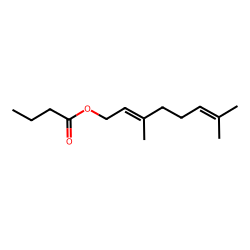


Najbliżsi sąsiedzi (cechy: Morgan) dla cząsteczki 'geranyl butyrate' (idx=223):


,idx,name,distance,smiles,labels
0,4417,neryl butyrate,0.000000,CCCC(=O)OC/C=C(/C)\CCC=C(C)C,"[sweet, fatty, leafy, oily, orange, green, waxy]"
1,140,geranyl valerate,2.449490,CCCCC(=O)OC/C=C(\C)/CCC=C(C)C,"[floral, fruity, pineapple, rose]"
2,193,neryl propionate,2.645751,CCC(=O)OC/C=C(/C)\CCC=C(C)C,"[sweet, berry, floral, fruity, jammy, powdery,..."
3,31,geranyl hexanoate,2.645751,CCCCCC(=O)OC/C=C(\C)/CCC=C(C)C,"[floral, rose, fruity, geranium, waxy]"
4,192,geranyl propionate,2.645751,CCC(=O)OC/C=C(\C)/CCC=C(C)C,"[vegetable, floral, rose, honey, fruity, powde..."


,idx,name,distance,smiles,labels
0,4417,neryl butyrate,0.000000,CCCC(=O)OC/C=C(/C)\CCC=C(C)C,"[sweet, fatty, leafy, oily, orange, green, waxy]"
1,140,geranyl valerate,2.449490,CCCCC(=O)OC/C=C(\C)/CCC=C(C)C,"[floral, fruity, pineapple, rose]"
2,193,neryl propionate,2.645751,CCC(=O)OC/C=C(/C)\CCC=C(C)C,"[sweet, berry, floral, fruity, jammy, powdery,..."
3,31,geranyl hexanoate,2.645751,CCCCCC(=O)OC/C=C(\C)/CCC=C(C)C,"[floral, rose, fruity, geranium, waxy]"
4,192,geranyl propionate,2.645751,CCC(=O)OC/C=C(\C)/CCC=C(C)C,"[vegetable, floral, rose, honey, fruity, powde..."


In [22]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def show_nearest_neighbors_with_mol(
    query_idx=None, 
    query_name=None, 
    X=None, 
    df=None, 
    n_neighbors=5, 
    feature_type='Morgan'
):
    """
    Pokazuje najbliższych sąsiadów i rysuje cząsteczkę zapytania.
    - query_idx: indeks cząsteczki w df
    - query_name: nazwa cząsteczki (kolumna 'name' w df)
    - X: macierz cech (np. feature_sets['Morgan'])
    - df: oryginalny DataFrame z kolumną 'name', 'mol', 'IsomericSMILES'
    - n_neighbors: ilu sąsiadów pokazać
    - feature_type: tylko do informacji w wypisie
    """
    if X is None or df is None:
        raise ValueError("Podaj X (macierz cech) i df (DataFrame z nazwami)!")
    if query_idx is None:
        if query_name is not None:
            query_idx = df.index[df['name'] == query_name].tolist()[0]
        else:
            raise ValueError("Podaj query_idx lub query_name!")
    # Rysuj cząsteczkę zapytania
    mol = df.iloc[query_idx]['mol']
    smiles = df.iloc[query_idx]['IsomericSMILES']
    nazwa = df.iloc[query_idx]['name']
    print(f"Wybrana cząsteczka: {nazwa}")
    print(f"SMILES: {smiles}")
    display(Draw.MolToImage(mol, size=(250, 250)))
    # KNN
    from sklearn.neighbors import NearestNeighbors
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(X)
    dists, indices = knn.kneighbors([X[query_idx]])
    dists = dists[0][1:]
    indices = indices[0][1:]
    results = []
    for dist, idx in zip(dists, indices):
        row = df.iloc[idx]
        results.append({
            'idx': idx,
            'name': row['name'],
            'distance': dist,
            'smiles': row['IsomericSMILES'],
            'labels': row['Labels']
        })
    results_df = pd.DataFrame(results)
    print(f"\nNajbliżsi sąsiedzi (cechy: {feature_type}) dla cząsteczki '{nazwa}' (idx={query_idx}):")
    display(results_df)
    return results_df

# Przykład użycia:
show_nearest_neighbors_with_mol(query_name='geraniol', X=feature_sets['Morgan'], df=df, n_neighbors=5, feature_type='Morgan')
# show_nearest_neighbors_with_mol(query_idx=4, X=feature_sets['Mordred'], df=df, n_neighbors=5, feature_type='Mordred')


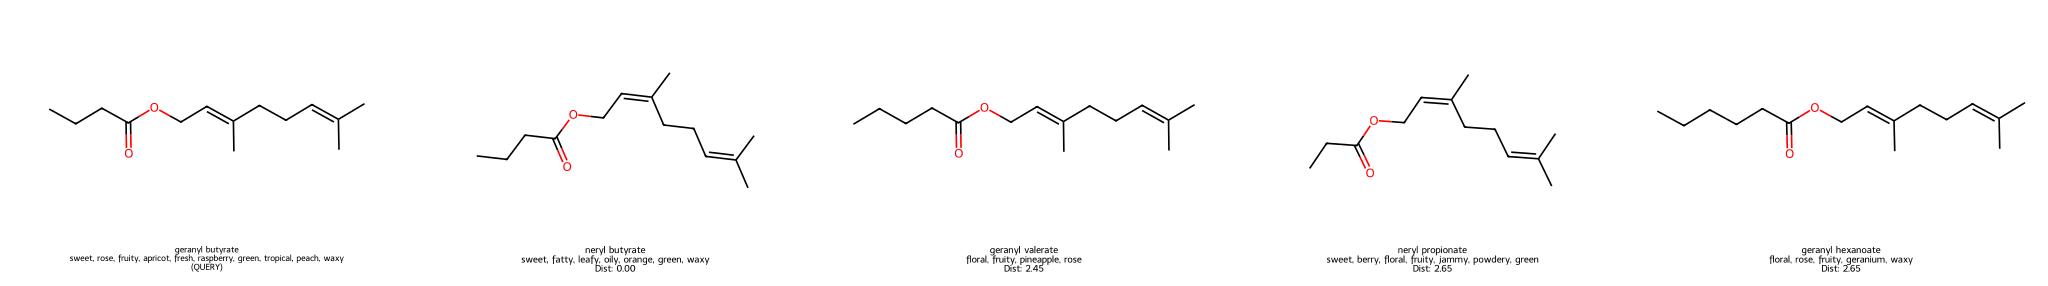

QUERY: geranyl butyrate | CCCC(=O)OC/C=C(\C)/CCC=C(C)C
Zapachy: sweet, rose, fruity, apricot, fresh, raspberry, green, tropical, peach, waxy

Najbliżsi sąsiedzi (Morgan):
- neryl butyrate | CCCC(=O)OC/C=C(/C)\CCC=C(C)C
  Zapachy: sweet, fatty, leafy, oily, orange, green, waxy | Odległość: 0.00
- geranyl valerate | CCCCC(=O)OC/C=C(\C)/CCC=C(C)C
  Zapachy: floral, fruity, pineapple, rose | Odległość: 2.45
- neryl propionate | CCC(=O)OC/C=C(/C)\CCC=C(C)C
  Zapachy: sweet, berry, floral, fruity, jammy, powdery, green | Odległość: 2.65
- geranyl hexanoate | CCCCCC(=O)OC/C=C(\C)/CCC=C(C)C
  Zapachy: floral, rose, fruity, geranium, waxy | Odległość: 2.65


In [23]:
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import display
from sklearn.neighbors import NearestNeighbors

def show_query_and_neighbors(
    query_name=None,
    query_idx=None,
    X=None,  # cechy, np. feature_sets['Morgan']
    df=None, # oryginalny DataFrame
    n_neighbors=4,
    feature_type='Morgan'
):
    assert X is not None and df is not None, "Podaj X i df!"
    # Znajdź indeks jeśli podano nazwę
    if query_idx is None:
        if query_name is not None:
            query_idx = df.index[df['name'] == query_name].tolist()[0]
        else:
            raise ValueError("Podaj query_name lub query_idx!")
    # KNN
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(X)
    dists, indices = knn.kneighbors([X[query_idx]])
    # Pierwszy to zawsze sama cząsteczka
    neighbor_indices = indices[0][1:]
    neighbor_dists = dists[0][1:]

    # Przygotuj listę mols i legend
    mols = []
    legends = []

    # Najpierw cząsteczka zapytania
    query_row = df.iloc[query_idx]
    mols.append(query_row['mol'])
    legends.append(f"{query_row['name']}\n{', '.join(query_row['Labels'])}\n(QUERY)")

    # Potem sąsiedzi
    for idx, dist in zip(neighbor_indices, neighbor_dists):
        row = df.iloc[idx]
        mols.append(row['mol'])
        legends.append(f"{row['name']}\n{', '.join(row['Labels'])}\nDist: {dist:.2f}")

    # Wyświetl siatkę obrazków
    img = MolsToGridImage(
        mols,
        legends=legends,
        molsPerRow=5,
        subImgSize=(500, 350),
        useSVG=True
    )
    display(img)
    print(f"QUERY: {query_row['name']} | {query_row['IsomericSMILES']}")
    print(f"Zapachy: {', '.join(query_row['Labels'])}")
    print(f"\nNajbliżsi sąsiedzi ({feature_type}):")
    for idx, dist in zip(neighbor_indices, neighbor_dists):
        row = df.iloc[idx]
        print(f"- {row['name']} | {row['IsomericSMILES']}\n  Zapachy: {', '.join(row['Labels'])} | Odległość: {dist:.2f}")

# Przykład użycia:
show_query_and_neighbors(query_name='geraniol', X=feature_sets['Morgan'], df=df, n_neighbors=4, feature_type='Morgan')
# show_query_and_neighbors(query_idx=4, X=feature_sets['Mordred'], df=df, n_neighbors=4, feature_type='Mordred')


### Graph NN

In [24]:
from torch_geometric.data import Data
import torch

def mol_to_graph_data_obj(mol, label_vec):
    # Atomy
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum()])
    atom_features = torch.tensor(atom_features, dtype=torch.float)

    # Wiązania
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    # Etykiety
    y = torch.tensor(label_vec, dtype=torch.float)

    return Data(x=atom_features, edge_index=edge_index, y=y)


In [25]:
from torch_geometric.data import Dataset

class OdorGraphDataset(Dataset):
    def __init__(self, mols, label_matrix):
        super().__init__()
        self.mols = mols
        self.label_matrix = label_matrix

    def len(self):
        return len(self.mols)

    def get(self, idx):
        return mol_to_graph_data_obj(self.mols[idx], self.label_matrix[idx])


In [26]:
# Załóżmy, że masz MultiLabelBinarizer i Y = mlb.fit_transform(df['Labels'])
mols = list(df['mol'])
dataset = OdorGraphDataset(mols, Y)


In [37]:
from torch.utils.data import random_split

train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])


In [40]:
import torch.nn as nn
from torch_geometric.nn import NNConv, global_mean_pool

class SimpleMPNN(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.node_emb = nn.Linear(1, 32)
        self.conv1 = NNConv(32, 64, nn.Linear(1, 32*64))
        self.conv2 = NNConv(64, 64, nn.Linear(1, 64*64))
        self.fc = nn.Linear(64, num_labels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.node_emb(x)
        edge_attr = torch.ones(edge_index.shape[1], 1, device=x.device)
        x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr).relu()
        x = global_mean_pool(x, batch)  # batch: [łączna_liczba_atomów]
        out = self.fc(x)
        return out


In [41]:
from torch_geometric.loader import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMPNN(num_labels=Y.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

for epoch in range(10):  # 10 epok dla przykładu
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {loss.item():.4f}")


ValueError: Target size (torch.Size([4256])) must be the same as input size (torch.Size([32, 133]))